# Affinity vs concentration footprinting

For KLF, OCTSOX and maybe some other motifs, perform footprinting for different affinity buckets and difference cell states.

In [1]:
import modisco
import h5py
import deepdish
import intervaltree
from collections import defaultdict, OrderedDict, Counter
from modisco.visualization import viz_sequence
import matplotlib

# for pdf text saving 
matplotlib.rcParams['pdf.fonttype'] = 42

from matplotlib import pyplot as plt
import numpy as np
import tqdm
import modisco
from modisco.visualization import viz_sequence
import tqdm
import pyBigWig
import pyfaidx
from math import ceil

In [2]:
import keras
from keras.utils import CustomObjectScope

import sys
sys.path.append("/users/surag/kundajelab/chrombpnet-lite/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils import shap_utils
import shap
from pathlib import Path
import pandas as pd

Using TensorFlow backend.
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/s

In [3]:
!pip freeze | grep modisco

modisco==0.5.15.0


In [4]:
import os

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [6]:
def revcomp(x):
    # Assuming ACGT
    return x[::-1][:,::-1]

## Load Config

In [7]:
config = pd.read_csv("../configs/cluster.tsv", sep='\t')
config

,cluster,colour,description,new_cluster
0,1,#B03743,Fibroblast,1
1,2,#E85F6D,Fibroblast-like,3
2,3,#7C2730,Fibroblast-like,2
3,4,#F0A118,Intermediate,12
4,5,#78A824,Pre-iPSC,13
5,6,#A6D854,Pre-iPSC,14
6,7,#F01D35,Fibroblast-like,5
7,8,#13C4A3,iPSC,15
8,9,#406614,Partially-reprogrammed,10
9,10,#D4B81C,Intermediate,9


## Load Models

In [8]:
CELL_STATES = [11,14,4,5,6,8,1]

In [9]:
MODEL_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/"

In [11]:
# load models
bias_models = dict()
models = dict()
with CustomObjectScope({'multinomial_nll': multinomial_nll}):
    for x in CELL_STATES:
        model_paths = list(Path(MODEL_BASE).glob("cluster_idx{}/*.h5".format(x)))
        assert(len(model_paths)==2)
        
        bias_model_path = str([x for x in model_paths if "adjusted" in str(x)][0])
        model_path = str([x for x in model_paths if "adjusted" not in str(x)][0])
        print(bias_model_path)
        print(model_path)
        models[x] = keras.models.load_model(model_path)
        bias_models[x] = keras.models.load_model(bias_model_path)

/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/VVoE9.adjusted_bias_model.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/VVoE9.h5


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx14/I55cu.adjusted_bias_model.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx14/I55cu.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx4/2nVk5.adjusted_bias_model.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx4/2nVk5.h5
/oak/stanford/groups/akundaje/surag/projects/scATAC-repr

In [12]:
profile_explainers = dict()

for x in CELL_STATES:
    weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(models[x])
    profile_explainers[x] = shap.explainers.deep.TFDeepExplainer(
        ([models[x].input[0], models[x].input[1]], weightedsum_meannormed_logits),
        shap_utils.shuffle_several_times,
        combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

In [13]:
MODEL_INP_LEN = models[CELL_STATES[0]].input_shape[0][1]
MODEL_INP_LEN

2000

In [14]:
MODEL_OUT_LEN = models[CELL_STATES[0]].output_shape[0][1]
MODEL_OUT_LEN

2000

In [15]:
assert(MODEL_INP_LEN==bias_models[CELL_STATES[0]].input_shape[1])

### Get sequences of negative regions for each cell state

In [16]:
def get_seq(genome, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)]))
        
    return one_hot.dna_to_one_hot(vals)

In [17]:
NEG_REGION_BASE = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/data/20210818_n62599/peaks/gc_neg/cluster_idx{}.gc.neg.bed"

In [18]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [19]:
SUBSAMPLE = 5000
gc_neg_per_state = dict()
for x in CELL_STATES:
    cur_gc_neg_peaks_df =  pd.read_csv(NEG_REGION_BASE.format(x),
                                       sep='\t',
                                       names=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"])
    
    cur_gc_neg_peaks_df = cur_gc_neg_peaks_df.sample(SUBSAMPLE)
    
    gc_neg_per_state[x] = get_seq(hg38, cur_gc_neg_peaks_df, MODEL_INP_LEN)

## Load Motif Data

In [20]:
# will crop to this region around center (summit of peak) [this is what was done for this data when modisco was called]
MODISCO_CROP_WIDTH = 500

In [21]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [22]:
def get_regions(regions_file, crop_width):
    with open(regions_file) as f:
        scored_regions = [x.strip().split('\t') for x in f]

    # importance scores are computed centered at summit (2nd col + 10th col)
    scored_regions = [(x[0], int(x[9])+int(x[1])-crop_width//2, int(x[9])+int(x[1])+crop_width//2) for x in scored_regions]
    
    return scored_regions

In [23]:
def fetch_data(modisco_hdf5, pattern_name, pattern_start, pattern_end,
               imp_scores, regions, insertions_bw_file, 
               pred_w_bias_bw_file, pred_wo_bias_bw_file, 
               modisco_crop_width, genome, rc_everything=False, expand_bw=100):
    """
    this function basically goes through the seqlets of a given pattern (pattern_name)
    it pulls out raw shap scores for each seqlet, its coordinates, whether it's RC-ed,
    its subcluster indices
    also pulls out raw insertions for each seqlet (out expand_bw on both sides), and same
    for predicted profiles w/ and w/o bias 
    
    returned seqlets all have the same orientation!
    pattern_start -> start of pattern within seqlet ([0,seqlen_len)]
    pattern_end-> start of pattern within seqlen ((pattern_start,seqlen_len)]
    """
    
    assert(len(regions)==imp_scores['shap']['seq'].shape[0])
    
    # region sliced out and used for modisco
    imp_width = imp_scores['shap']['seq'].shape[-1]
    imp_crop_start = imp_width//2 - modisco_crop_width//2
    imp_crop_end = imp_width//2 + modisco_crop_width//2
    
    pattern = modisco_hdf5['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns'][pattern_name]
    
    seqlet_len = pattern["sequence"]["fwd"].shape[0]
    
    subcluster_idxs = np.array(list(pattern["subclusters"]))
    
    insertions_bw = pyBigWig.open(insertions_bw_file)
    pred_w_bias_bw = pyBigWig.open(pred_w_bias_bw_file)
    pred_wo_bias_bw = pyBigWig.open(pred_wo_bias_bw_file)
    
    seqlet_coords = []
    seqlet_is_rc = []
    seqlet_shaps = []
    seqlet_one_hots = []
    seqlet_pred_wo_bias = []
    seqlet_pred_w_bias = []
    seqlet_insertions = []
    
    # fetch info from the bigwigs where the seqlets are present
    for i in tqdm.trange(len(pattern['seqlets_and_alnmts']['seqlets'])):
        x = pattern['seqlets_and_alnmts']['seqlets'][i]
        
        # index into regions/imp_scores, i.e. which entry in regions does each seqlet come from
        idx = int(x.decode('utf8').split(',')[0].split(':')[1])
        start = int(x.decode('utf8').split(',')[1].split(':')[1])
        rc = eval(x.decode('utf8').split(',')[3].split(':')[1])

        reg = regions[idx]

        cur_proj_shap_scores = imp_scores['projected_shap']['seq'][idx][:, imp_crop_start:imp_crop_end].transpose()
        cur_one_hot = imp_scores['raw']['seq'][idx][:, imp_crop_start:imp_crop_end].transpose()

        seqlet_is_rc.append(rc)
        
        if rc:
            seqlet_shaps.append(revcomp(cur_proj_shap_scores[start+(seqlet_len-pattern_end):start+(seqlet_len-pattern_start)]))
            seqlet_one_hots.append(revcomp(cur_one_hot[start+(seqlet_len-pattern_end):start+(seqlet_len-pattern_start)]))

            start_coord = reg[1]+start+(seqlet_len-pattern_end)
            end_coord = reg[1]+start+(seqlet_len-pattern_start)
            seqlet_coords.append([reg[0], start_coord, end_coord])
            
            start_coord_expanded = start_coord - expand_bw
            end_coord_expanded = end_coord + expand_bw
            
            seqlet_pred_wo_bias.append(np.nan_to_num(pred_wo_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded))[::-1])
            seqlet_pred_w_bias.append(np.nan_to_num(pred_w_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded))[::-1])
            seqlet_insertions.append(np.nan_to_num(insertions_bw.values(reg[0], start_coord_expanded, end_coord_expanded))[::-1])

        else:
            seqlet_shaps.append(cur_proj_shap_scores[start+pattern_start:start+pattern_end])
            seqlet_one_hots.append(cur_one_hot[start+pattern_start:start+pattern_end])
            
            start_coord = reg[1]+start+pattern_start
            end_coord = reg[1]+start+pattern_end
            seqlet_coords.append([reg[0], start_coord, end_coord])
            
            start_coord_expanded = start_coord - expand_bw
            end_coord_expanded = end_coord + expand_bw

            seqlet_pred_wo_bias.append(np.nan_to_num(pred_wo_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded)))
            seqlet_pred_w_bias.append(np.nan_to_num(pred_w_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded)))    
            seqlet_insertions.append(np.nan_to_num(insertions_bw.values(reg[0], start_coord_expanded, end_coord_expanded)))
    
    insertions_bw.close()
    pred_w_bias_bw.close()
    pred_wo_bias_bw.close()
    
    # RC-ing all instances
    seqlet_shaps = np.array(seqlet_shaps) #[:,::-1,::-1]
    seqlet_one_hots = np.array(seqlet_one_hots)  # [:,::-1,::-1]
    seqlet_pred_wo_bias = np.array(seqlet_pred_wo_bias)
    seqlet_pred_w_bias = np.array(seqlet_pred_w_bias)
    seqlet_insertions = np.array(seqlet_insertions)
    
    if rc_everything:
        seqlet_shaps = seqlet_shaps[:, ::-1, ::-1]
        seqlet_one_hots = seqlet_one_hots[:, ::-1, ::-1]
        seqlet_pred_wo_bias = seqlet_pred_wo_bias[:, ::-1]
        seqlet_pred_w_bias = seqlet_pred_w_bias[:, ::-1]
        seqlet_insertions = seqlet_insertions[:, ::-1]
    
    return seqlet_coords, seqlet_is_rc, subcluster_idxs, seqlet_shaps, seqlet_one_hots, seqlet_insertions, seqlet_pred_w_bias, seqlet_pred_wo_bias

### High OSK MoDISco [OCT-SOX, KLF and SOX motifs]

In [23]:
HIGH_OSK_MODISCO_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/modisco/modisco_results_allChroms_counts.hdf5"
HIGH_OSK_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/interpret/counts_scores.h5"
HIGH_OSK_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/interpret/interpreted_regions.bed"

In [24]:
high_OSK_modisco = h5py.File(HIGH_OSK_MODISCO_PATH, 'r')

In [25]:
high_OSK_imp_scores = deepdish.io.load(HIGH_OSK_HDF5_PATH)

In [26]:
high_OSK_regions = get_regions(HIGH_OSK_REG_PATH, MODISCO_CROP_WIDTH)

In [27]:
# patterns

# OS: pattern_0 : 8 - 24
# KLF: pattern_1 : 6 - 16

In [28]:
KLF_coords, KLF_is_rc, \
KLF_subcluster_idxs, \
KLF_shaps, KLF_one_hots, \
KLF_insertions, KLF_pred_w_bias,\
KLF_pred_wo_bias = \
        fetch_data(high_OSK_modisco, "pattern_1", 6, 16,
                   high_OSK_imp_scores, high_OSK_regions, 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx11.bw", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_w_bias.bw",
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_wo_bias.bw",
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 6288/6288 [00:46<00:00, 135.94it/s]


In [29]:
OS_coords, OS_is_rc, \
OS_subcluster_idxs, \
OS_shaps, OS_one_hots, \
OS_insertions, OS_pred_w_bias,\
OS_pred_wo_bias = \
        fetch_data(high_OSK_modisco, "pattern_0", 8, 24,
                   high_OSK_imp_scores, high_OSK_regions, 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx11.bw", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_w_bias.bw",
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_wo_bias.bw",
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 9502/9502 [00:10<00:00, 935.83it/s] 


In [30]:
SOX_coords, SOX_is_rc, \
SOX_subcluster_idxs, \
SOX_shaps, SOX_one_hots, \
SOX_insertions, SOX_pred_w_bias,\
SOX_pred_wo_bias = \
        fetch_data(high_OSK_modisco, "pattern_4", 6, 15,
                   high_OSK_imp_scores, high_OSK_regions, 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx11.bw", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_w_bias.bw",
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_wo_bias.bw",
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 585/585 [00:00<00:00, 952.45it/s]


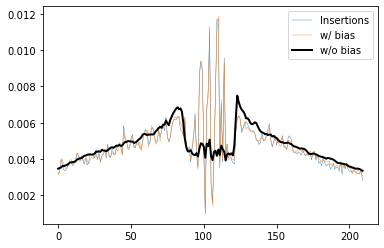

In [35]:
plt.plot(np.array([x/sum(x) for x in KLF_insertions if sum(x)>0]).mean(0), label="Insertions", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in KLF_pred_w_bias]).mean(0), label="w/ bias", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in KLF_pred_wo_bias]).mean(0), label="w/o bias", linewidth=2, c='k')
plt.legend()

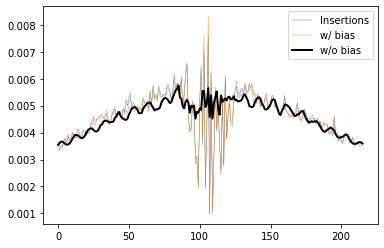

In [36]:
plt.plot(np.array([x/sum(x) for x in OS_insertions if sum(x)>0]).mean(0), label="Insertions", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in OS_pred_w_bias]).mean(0), label="w/ bias", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in OS_pred_wo_bias]).mean(0), label="w/o bias", linewidth=2, c='k')
plt.legend()

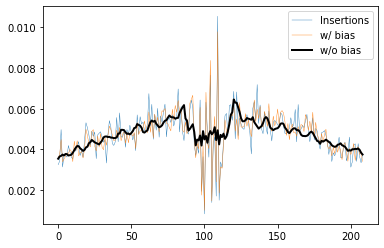

In [37]:
plt.plot(np.array([x/sum(x) for x in SOX_insertions if sum(x)>0]).mean(0), label="Insertions", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in SOX_pred_w_bias]).mean(0), label="w/ bias", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in SOX_pred_wo_bias]).mean(0), label="w/o bias", linewidth=2, c='k')
plt.legend()

## Computing log-odds scores

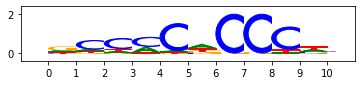

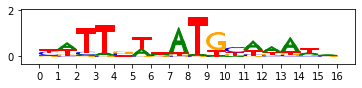

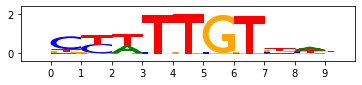

In [38]:
for x in [KLF_one_hots, OS_one_hots, SOX_one_hots]:
    viz_sequence.plot_weights(viz_sequence.ic_scale(x.mean(0), background=[0.25]*4), 
                              figsize=(6,1))

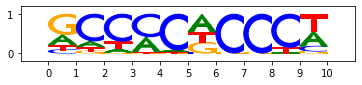

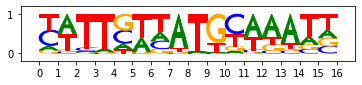

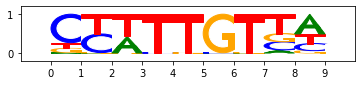

In [39]:
for x in [KLF_one_hots, OS_one_hots, SOX_one_hots]:
    viz_sequence.plot_weights(x.mean(0), 
                              figsize=(6,1))

In [40]:
from random import sample, randint, shuffle

In [41]:
KLF_pwm = KLF_one_hots.mean(0)
KLF_logodds_mat = np.log((KLF_pwm+1e-10)/0.25)

In [42]:
OS_pwm = OS_one_hots.mean(0)
OS_logodds_mat = np.log((OS_pwm+1e-10)/0.25)

In [43]:
SOX_pwm = SOX_one_hots.mean(0)
SOX_logodds_mat = np.log((SOX_pwm+1e-10)/0.25)

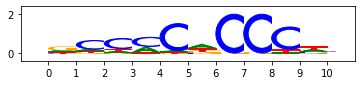

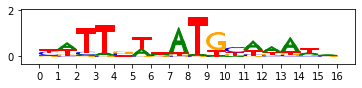

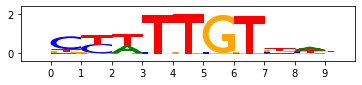

In [44]:
for x in [KLF_pwm, OS_pwm, SOX_pwm]:
    viz_sequence.plot_weights(viz_sequence.ic_scale(x, background=[0.25]*4), figsize=(6,1))

In [45]:
KLF_log_odd_scores = np.sum(KLF_one_hots*KLF_logodds_mat, axis=(1,2))
OS_log_odd_scores = np.sum(OS_one_hots*OS_logodds_mat, axis=(1,2))
SOX_log_odd_scores = np.sum(SOX_one_hots*SOX_logodds_mat, axis=(1,2))

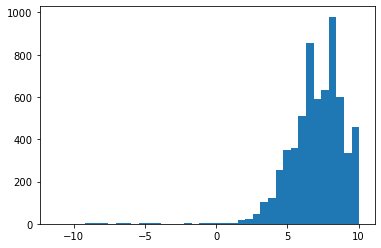

In [46]:
plt.hist(KLF_log_odd_scores, bins=40)
plt.show()

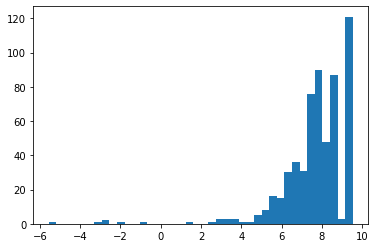

In [47]:
plt.hist(SOX_log_odd_scores, bins=40)
plt.show()

In [48]:
pwm_dict = {"KLF": {"pwm": KLF_pwm, "scores": KLF_log_odd_scores},
            "OCTSOX": {"pwm": OS_pwm, "scores": OS_log_odd_scores},
            "SOX": {"pwm": SOX_pwm, "scores": SOX_log_odd_scores}}

for x in pwm_dict:
    with open("./Supp/model_free_footprints/motifs/highOSK.{}.HOMER.motif".format(x), 'w') as f:
        f.write(">{}\t{}\t{}\t-\t-\t-\n".format(x,x,np.quantile(pwm_dict[x]["scores"], 0.1)))
        for y in pwm_dict[x]["pwm"]:
            f.write("\t".join([str(v) for v in y]) + "\n")

## Virtual Footprinting

Insert motifs of different affinities in negative regions for each model and visualize footprints.

In [24]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [25]:
def profiles_for_motif(model, model_bias, seqs, motifs_one_hot, rep_motifs=5):
    # rep motifs multiple times
    motifs_one_hot_rep = np.tile(motifs_one_hot, (rep_motifs, 1, 1))
    
    # choose one background for each motif
    idxs = np.random.choice(range(seqs.shape[0]), motifs_one_hot_rep.shape[0], replace=True)
    
    seqs_selected = seqs[idxs]
    w_mot_seqs = seqs_selected.copy()
    MID = MODEL_INP_LEN//2 - motifs_one_hot.shape[1]//2
    
    w_mot_seqs[:, MID:MID+motifs_one_hot.shape[1]] = motifs_one_hot_rep

    raw_seqs_pred_bias, raw_seqs_pred_cts = model_bias.predict(seqs_selected, verbose=True)
    w_mot_seqs_pred_bias, w_mot_seqs_pred_cts = model_bias.predict(w_mot_seqs, verbose=True)
    
    
    
    wo_mot_pred_w_bias, wo_mot_pred_w_bias_cts = model.predict([seqs_selected, 
                                                                raw_seqs_pred_bias,
                                                                raw_seqs_pred_cts], 
                                                               verbose=True)

    w_mot_pred_unplug_bias, _ = model.predict([w_mot_seqs, 
                                               np.zeros((w_mot_seqs_pred_bias.shape[0],MODEL_OUT_LEN)), 
                                                     np.zeros((w_mot_seqs_pred_bias.shape[0],1))],
                                              verbose=True)
    w_mot_pred_w_bias, w_mot_pred_w_bias_cts = model.predict([w_mot_seqs, 
                                                              w_mot_seqs_pred_bias,
                                                              w_mot_seqs_pred_cts], 
                                                             verbose=True)
    
    return(softmax(raw_seqs_pred_bias), softmax(w_mot_seqs_pred_bias), 
           softmax(wo_mot_pred_w_bias), softmax(w_mot_pred_w_bias), 
           softmax(w_mot_pred_unplug_bias),
           wo_mot_pred_w_bias_cts, w_mot_pred_w_bias_cts)

In [26]:
def shap_for_motif(model_profile_explainer, seqs, motifs_one_hot, rep_motifs=1):
    # rep motifs multiple times
    motifs_one_hot_rep = np.tile(motifs_one_hot, (rep_motifs, 1, 1))
    
    # choose one background for each motif
    idxs = np.random.choice(range(seqs.shape[0]), motifs_one_hot_rep.shape[0], replace=True)
    
    seqs_selected = seqs[idxs]
    w_mot_seqs = seqs_selected.copy()
    MID = MODEL_INP_LEN//2 - motifs_one_hot.shape[1]//2
    
    w_mot_seqs[:, MID:MID+motifs_one_hot.shape[1]] = motifs_one_hot_rep

    profile_input = [w_mot_seqs, np.zeros((w_mot_seqs.shape[0], MODEL_OUT_LEN))]
    
    profile_shap_scores = model_profile_explainer.shap_values(profile_input, 
                                                              progress_message=100)
    
    
    return w_mot_seqs*profile_shap_scores[0]

In [27]:
def plot_tracks(raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, start=950, end=1060):
    plt.rcParams["figure.figsize"] = (6,4)
    width = end - start
    plt.plot(range(width), pred_w_bias[:, start:end].mean(0), label='uncorrected')
    plt.plot(range(width), pred_unplug_bias[:, start:end].mean(0), label='corrected')
    plt.plot(range(width), pred_wo_motif_w_bias[:, start:end].mean(0), '--', label='uncorrected w/o motif')
    plt.legend()
    plt.show()

    plt.plot(range(width), raw_mot_bias[:, start:end].mean(0), label='bias w/ motif')
    plt.plot(range(width), raw_bias[:, start:end].mean(0), '--', label='bias w/o motif')
    plt.legend()
    plt.show()

In [72]:
# raw_bias, raw_mot_bias, pred_wo_motif_w_bias, pred_w_bias, pred_unplug_bias, wo_mot_w_bias_cts, w_mot_w_bias_cts = \
#   profiles_for_motif(models[5], bias_models[5], gc_neg_per_state[5], KLF_one_hots[KLF_log_odd_scores>9],
#                     rep_motifs=2)

In [45]:
aff_quants10 = [0.1*x for x in range(1,11)] # includes max
aff_quants3 = [0.1,.4,.7,1]

print(aff_quants10)
print(aff_quants3)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
[0.1, 0.4, 0.7, 1]


In [58]:
aff_vals = np.quantile(KLF_log_odd_scores, aff_quants3)

In [59]:
aff_dict = OrderedDict()
for i in range(len(aff_quants3)-1):
    aff_dict[i] = KLF_one_hots[(KLF_log_odd_scores>aff_vals[i])&(KLF_log_odd_scores<=aff_vals[i+1])]

In [60]:
[len(aff_dict[x]) for x in aff_dict]

[1880, 1980, 1792]

In [88]:
np.random.choice(range(10), 5)

array([6, 7, 0, 3, 9])

In [48]:
def make_footprint_grid(one_hots, log_odds_scores, aff_vals, cell_states, profile_sample=100, min_seq_per_element=1000):
    # aff_vals should look something like [v1,v2...vn,vmax] <-- max val at the end!!
    # takes motifs in each v_i v_{i+1}
    
    assert(list(aff_vals) == sorted(list(aff_vals)))
    
    aff_dict = OrderedDict()
    for i in range(len(aff_vals)-1):
        aff_dict[i] = one_hots[(log_odds_scores>aff_vals[i])&(log_odds_scores<=aff_vals[i+1])]
    
    cell_state_fp_w_bias = defaultdict(dict)
    cell_state_fp_debias = defaultdict(dict)
    cell_state_profile_imp = defaultdict(dict)

    for x in cell_states:
        for aff in aff_dict:
            _, _, _, raw_footprint, debiased_footprint, _, _ = profiles_for_motif(models[x], 
                                                                bias_models[x],
                                                                gc_neg_per_state[x],
                                                                aff_dict[aff], 
                                                                rep_motifs=ceil(min_seq_per_element/aff_dict[aff].shape[0]))

            cell_state_fp_w_bias[x][aff] = raw_footprint.mean(0)
            cell_state_fp_debias[x][aff] = debiased_footprint.mean(0)
            
            subset_for_shap = aff_dict[aff]
            subset_for_shap = subset_for_shap[np.random.choice(range(subset_for_shap.shape[0]), profile_sample)]

#             cell_state_profile_imp[x][aff]  = shap_for_motif(profile_explainers[x], 
#                                                              gc_neg_per_state[x], 
#                                                              subset_for_shap, 
#                                                              rep_motifs=1)
            
            
    
    return cell_state_fp_w_bias, cell_state_fp_debias #, cell_state_profile_imp

In [29]:
def plot_footprints_grid(wo_bias, w_bias, aff_vals, width=100, rev_y = False, add_w_bias=False):
    cell_states = list(wo_bias.keys())
    affs = list(wo_bias[cell_states[0]].keys())
    
    fig, axs = plt.subplots(len(affs), len(cell_states), figsize=(3*len(cell_states),4*len(affs)), sharey=True)
    
    start = len(wo_bias[cell_states[0]][affs[0]])//2-width//2
    end = len(wo_bias[cell_states[0]][affs[0]])//2+width//2
    
    for cidx,cs in enumerate(wo_bias):        
        for aidx,aff in enumerate(wo_bias[cs]):
            y_idx = aidx if not rev_y else len(affs)-aidx-1
                
            
            if add_w_bias:
                axs[y_idx][cidx].plot(range(-width//2, width//2), w_bias[cs][aff][start:end], 'r--', linewidth=0.5)
            
            axs[y_idx][cidx].plot(range(-width//2,width//2), wo_bias[cs][aff][start:end], 
                           c='k')
#                            c= config.iloc[cs-1]['colour'])

    for ax, col in zip(axs[0], cell_states):
        ax.set_title("{} - {}".format(config.iloc[col-1]["new_cluster"], 
                                      config.iloc[col-1]["description"]), 
                     size=16)

    for i in range(len(affs)-1):
        for j in range(len(cell_states)):
            axs[i][j].set_xticklabels([])

    y_labels = ["{:.1f} - {:.1f}".format(aff_vals[i], aff_vals[i+1]) for i in range(len(aff_vals)-1)]
    if rev_y:
        y_labels = y_labels[::-1]
    for ax, row in zip(axs[:, 0], y_labels):
        ax.set_ylabel(row, size=16)

    fig.suptitle('Cell State', size=20)
    fig.text(0.05, 0.5, 'Motif Affinity Bin', va='center', rotation='vertical', size=20)

In [30]:
def plot_shap_grid(shap_scores, width=100, rev_y = False, add_w_bias=False):
    cell_states = list(shap_scores.keys())
    affs = list(shap_scores[cell_states[0]].keys())
    
    fig, axs = plt.subplots(len(affs), len(cell_states), figsize=(3*len(cell_states),4*len(affs)), sharey=True)
    
    start = shap_scores[cell_states[0]][affs[0]].shape[1]//2-width//2
    end = shap_scores[cell_states[0]][affs[0]].shape[1]//2+width//2
    
    for cidx,cs in enumerate(shap_scores):        
        for aidx,aff in enumerate(shap_scores[cs]):
            y_idx = aidx if not rev_y else len(affs)-aidx-1
                
            viz_sequence.plot_weights_given_ax(axs[y_idx][cidx], shap_scores[cs][aff].mean(0)[start:end])
            

    for ax, col in zip(axs[0], cell_states):
        ax.set_title("{} - {}".format(config.iloc[col-1]["new_cluster"], 
                                      config.iloc[col-1]["description"]), 
                     size=16)

    for i in range(len(affs)-1):
        for j in range(len(cell_states)):
            axs[i][j].set_xticklabels([])

    y_labels = ["{:.1f} - {:.1f}".format(aff_vals[i], aff_vals[i+1]) for i in range(len(aff_vals)-1)]
    if rev_y:
        y_labels = y_labels[::-1]
    for ax, row in zip(axs[:, 0], y_labels):
        ax.set_ylabel(row, size=16)

    fig.suptitle('Cell State', size=20)
    fig.text(0.05, 0.5, 'Motif Affinity Bin', va='center', rotation='vertical', size=20)

In [67]:
KLF_q3_aff_vals = np.quantile(KLF_log_odd_scores, aff_quants3)

In [100]:
CELL_STATES

[11, 14, 4, 5, 6, 8, 1]

In [132]:
KLF_q3_w_bias, KLF_q3_wo_bias, KLF_q3_shap = make_footprint_grid(KLF_one_hots, #[:100], 
                                                                 KLF_log_odd_scores, #[:100], 
                                                                 KLF_q3_aff_vals, 
                                                                 [11,14,6,8,1], 
                                                                 100, 
                                                                 1000)

1880/1880 [==============================] - 3s 1ms/step
Done 0 examples of 100
1980/1980 [==============================] - 3s 1ms/step
Done 0 examples of 100
1792/1792 [==============================] - 2s 1ms/step
Done 0 examples of 100
1880/1880 [==============================] - 3s 1ms/step
Done 0 examples of 100
1980/1980 [==============================] - 3s 1ms/step
Done 0 examples of 100
1792/1792 [==============================] - 2s 1ms/step
Done 0 examples of 100
1880/1880 [==============================] - 3s 1ms/step
Done 0 examples of 100
1980/1980 [==============================] - 3s 1ms/step
Done 0 examples of 100
1792/1792 [==============================] - 2s 1ms/step
Done 0 examples of 100
1880/1880 [==============================] - 3s 1ms/step
Done 0 examples of 100
1980/1980 [==============================] - 3s 1ms/step
Done 0 examples of 100
1792/1792 [==============================] - 2s 1ms/step
Done 0 examples of 100
1880/1880 [=============================

In [106]:
KLF_q3_shap[11].keys()

dict_keys([0, 1, 2])

In [120]:
enumerate(KLF_q3_wo_bias[11])

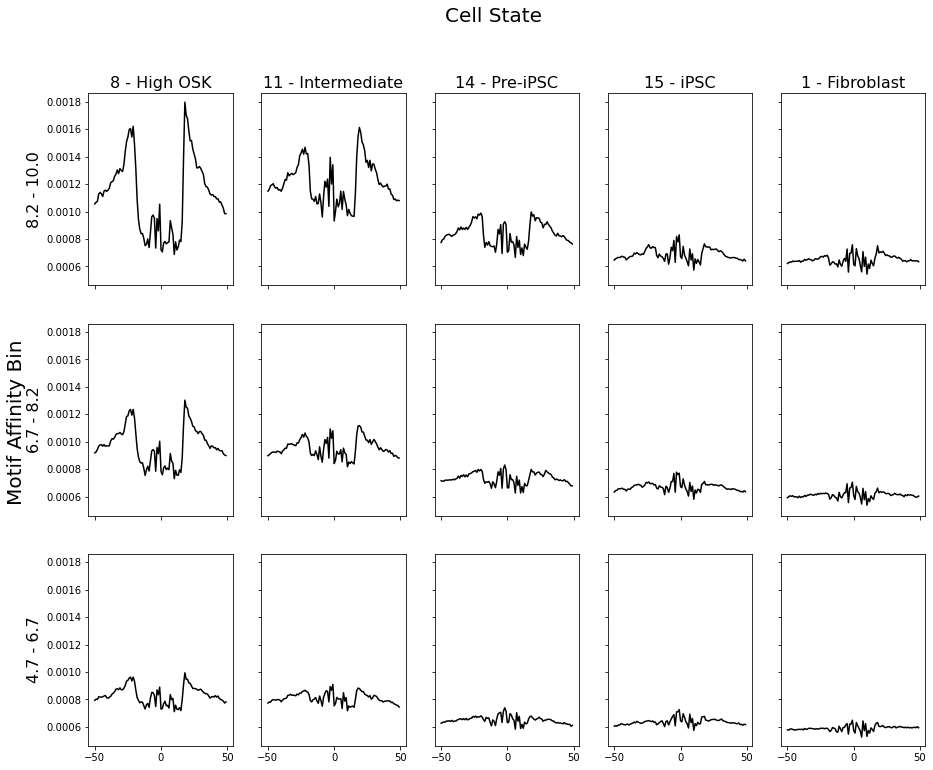

In [133]:
plot_footprints_grid(KLF_q3_wo_bias, KLF_q3_w_bias, KLF_q3_aff_vals, rev_y=True)
# plt.savefig("./subfigs/footprinting/virtual/KLF_q3_wo_bias.pdf")

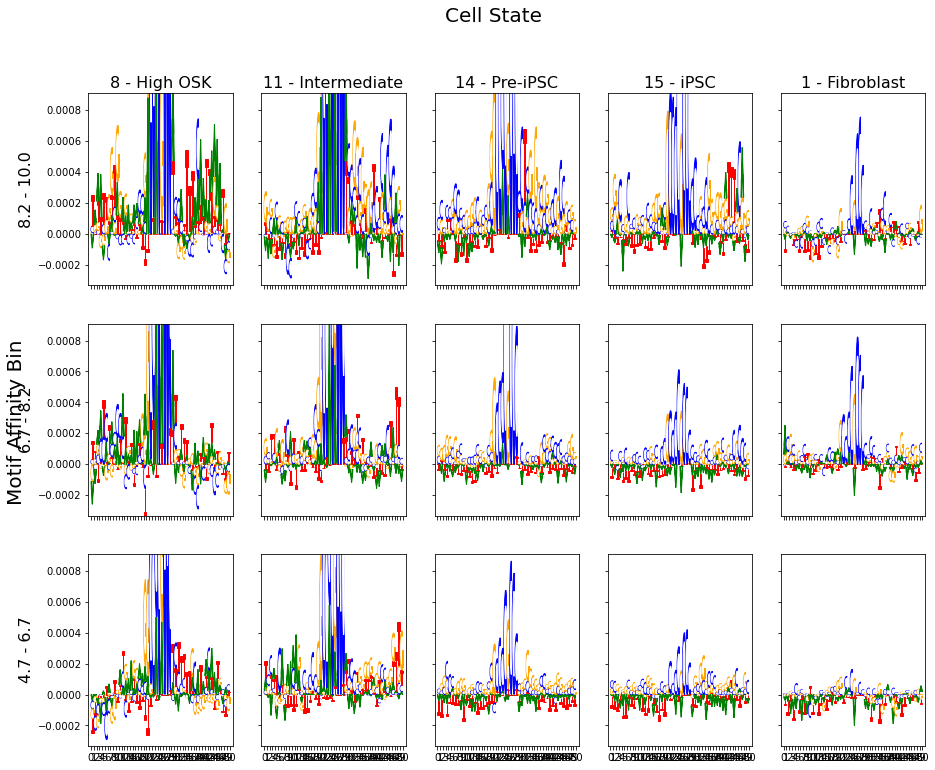

In [147]:
plot_shap_grid(KLF_q3_shap, width=50, rev_y=True)
# plt.savefig("./subfigs/footprinting/virtual/KLF_q3_wo_bias.pdf")

In [611]:
KLF_q3_aff_vals = np.quantile(KLF_log_odd_scores, aff_quants3)

In [544]:
KLF_q3_w_bias, KLF_q3_wo_bias = plot_footprint_grid(KLF_one_hots, KLF_log_odd_scores, aff_quants3, CELL_STATES, 1)

1792/1792 [==============================] - 2s 1ms/step


In [ ]:
plot_footprints_grid(KLF_q3_wo_bias, KLF_q3_w_bias, KLF_q3_aff_vals, rev_y=True)
plt.savefig("./subfigs/footprinting/virtual/KLF_q3_wo_bias.pdf")

In [ ]:
motif_dict = {"KLF": {"one_hot":KLF_one_hots, "log_odds_scores":KLF_log_odd_scores},
                 "OCTSOX": {"one_hot": OS_one_hots, "log_odds_scores": OS_log_odd_scores},
                  "SOX": {"one_hot": SOX_one_hots, "log_odds_scores": SOX_log_odd_scores}}
    
aff_dict = {'q3':aff_quants3, 'q10':aff_quants10}

MIN_SEQ_PER_GRID_ELEMENT = 1000

for aff_q in aff_dict:
    for motif in motif_dict:
        aff_vals = np.quantile(motif_dict[motif]["log_odds_scores"], aff_dict[aff_q])
        
        fp_w_bias, fp_wo_bias = make_footprint_grid(motif_dict[motif]["one_hot"], motif_dict[motif]["log_odds_scores"], aff_vals, CELL_STATES, min_seq_per_element=MIN_SEQ_PER_GRID_ELEMENT)
        
        plot_footprints_grid(fp_wo_bias, fp_w_bias, aff_vals, rev_y=True)
        plt.savefig("./subfigs/footprinting/virtual/{}_{}_wo_bias.pdf".format(motif, aff_q))
        plt.clf()
        
        plot_footprints_grid(fp_wo_bias, fp_w_bias, aff_vals, rev_y=True, add_w_bias=True)
        plt.savefig("./subfigs/footprinting/virtual/{}_{}_w_bias.pdf".format(motif, aff_q))
        plt.clf()

  96/1420 [=>............................] - ETA: 1s

## AP1

In [671]:
FIBR_MODISCO_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/modisco/modisco_results_allChroms_counts.hdf5"
FIBR_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/interpret/counts_scores.h5"
FIBR_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/interpret/interpreted_regions.bed"

In [672]:
fibr_modisco = h5py.File(FIBR_MODISCO_PATH, 'r')

In [673]:
fibr_imp_scores = deepdish.io.load(FIBR_HDF5_PATH)

In [674]:
fibr_regions = get_regions(FIBR_REG_PATH, MODISCO_CROP_WIDTH)

In [675]:
# patterns

# AP1: pattern_1 : 5 - 16

In [677]:
AP1_coords, AP1_is_rc, \
AP1_subcluster_idxs, \
AP1_shaps, AP1_one_hots, \
AP1_insertions, AP1_pred_w_bias,\
AP1_pred_wo_bias = \
        fetch_data(fibr_modisco, "pattern_1", 5, 16,
                   fibr_imp_scores, fibr_regions, 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx1.bw", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/predict/cluster_idx1_w_bias.bw",
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/predict/cluster_idx1_wo_bias.bw",
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 5056/5056 [00:49<00:00, 101.73it/s]


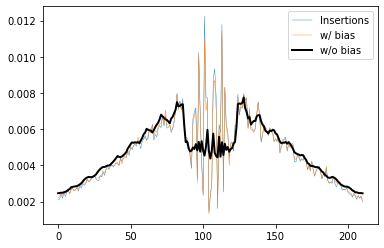

In [682]:
plt.plot(np.array([x/sum(x) for x in AP1_insertions if sum(x)>0]).mean(0), label="Insertions", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in AP1_pred_w_bias]).mean(0), label="w/ bias", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in AP1_pred_wo_bias]).mean(0), label="w/o bias", linewidth=2, c='k')
plt.legend()

In [678]:
AP1_pwm = AP1_one_hots.mean(0)
AP1_logodds_mat = np.log((AP1_pwm+1e-10)/0.25)

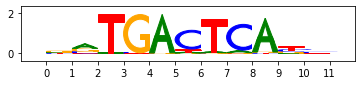

In [679]:
viz_sequence.plot_weights(viz_sequence.ic_scale(AP1_pwm, background=[0.25]*4), figsize=(6,1))

In [680]:
AP1_log_odd_scores = np.sum(AP1_one_hots*AP1_logodds_mat, axis=(1,2))

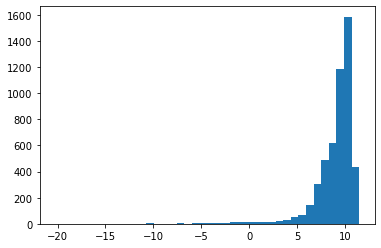

In [681]:
plt.hist(AP1_log_odd_scores, bins=40)
plt.show()

In [698]:
pwm_dict = {"AP1": {"pwm": AP1_pwm, "scores": AP1_log_odd_scores}}

for x in pwm_dict:
    with open("./Supp/model_free_footprints/motifs/fibr.{}.HOMER.motif".format(x), 'w') as f:
        f.write(">{}\t{}\t{}\t-\t-\t-\n".format(x,x,np.quantile(pwm_dict[x]["scores"], 0.1)))
        for y in pwm_dict[x]["pwm"]:
            f.write("\t".join([str(v) for v in y]) + "\n")

In [684]:
motif_dict = {"AP1": {"one_hot":AP1_one_hots, "log_odds_scores":AP1_log_odd_scores}}    
aff_dict = {'q3':aff_quants3, 'q10':aff_quants10}

MIN_SEQ_PER_GRID_ELEMENT = 1000

for aff_q in aff_dict:
    for motif in motif_dict:
        aff_vals = np.quantile(motif_dict[motif]["log_odds_scores"], aff_dict[aff_q])
        
        fp_w_bias, fp_wo_bias = make_footprint_grid(motif_dict[motif]["one_hot"], motif_dict[motif]["log_odds_scores"], aff_vals, [1]+ CELL_STATES[:-1], 
                                                    min_seq_per_element=MIN_SEQ_PER_GRID_ELEMENT)
        
        plot_footprints_grid(fp_wo_bias, fp_w_bias, aff_vals, rev_y=True)
        plt.savefig("./subfigs/footprinting/virtual/{}_{}_wo_bias.pdf".format(motif, aff_q))
        plt.clf()
        
        plot_footprints_grid(fp_wo_bias, fp_w_bias, aff_vals, rev_y=True, add_w_bias=True)
        plt.savefig("./subfigs/footprinting/virtual/{}_{}_w_bias.pdf".format(motif, aff_q))
        plt.clf()

1482/1482 [==============================] - 2s 1ms/step


<Figure size 1512x864 with 0 Axes>

<Figure size 1512x864 with 0 Axes>

<Figure size 1512x2592 with 0 Axes>

<Figure size 1512x2592 with 0 Axes>

## CTCF

In [31]:
FIBR_MODISCO_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/modisco/modisco_results_allChroms_counts.hdf5"
FIBR_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/interpret/counts_scores.h5"
FIBR_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/interpret/interpreted_regions.bed"

In [32]:
fibr_modisco = h5py.File(FIBR_MODISCO_PATH, 'r')

In [33]:
fibr_imp_scores = deepdish.io.load(FIBR_HDF5_PATH)

In [34]:
fibr_regions = get_regions(FIBR_REG_PATH, MODISCO_CROP_WIDTH)

In [675]:
# patterns

# AP1: pattern_0 : 5 - 16

In [35]:
CTCF_coords, CTCF_is_rc, \
CTCF_subcluster_idxs, \
CTCF_shaps, CTCF_one_hots, \
CTCF_insertions, CTCF_pred_w_bias,\
CTCF_pred_wo_bias = \
        fetch_data(fibr_modisco, "pattern_0", 5, 25,
                   fibr_imp_scores, fibr_regions, 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx1.bw", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/predict/cluster_idx1_w_bias.bw",
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/predict/cluster_idx1_wo_bias.bw",
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 5944/5944 [00:38<00:00, 153.53it/s]


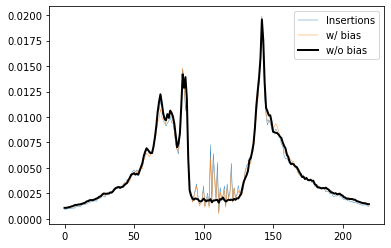

In [37]:
plt.plot(np.array([x/sum(x) for x in CTCF_insertions if sum(x)>0]).mean(0), label="Insertions", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in CTCF_pred_w_bias]).mean(0), label="w/ bias", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in CTCF_pred_wo_bias]).mean(0), label="w/o bias", linewidth=2, c='k')
plt.legend()

In [38]:
CTCF_pwm = CTCF_one_hots.mean(0)
CTCF_logodds_mat = np.log((CTCF_pwm+1e-10)/0.25)

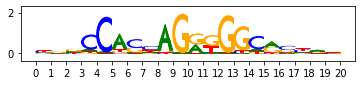

In [40]:
viz_sequence.plot_weights(viz_sequence.ic_scale(CTCF_pwm, background=[0.25]*4), figsize=(6,1))

In [41]:
CTCF_log_odd_scores = np.sum(CTCF_one_hots*CTCF_logodds_mat, axis=(1,2))

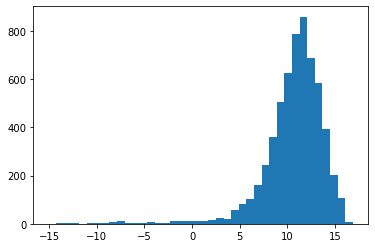

In [42]:
plt.hist(CTCF_log_odd_scores, bins=40)
plt.show()

In [43]:
pwm_dict = {"CTCF": {"pwm": CTCF_pwm, "scores": CTCF_log_odd_scores}}

for x in pwm_dict:
    with open("./Supp/model_free_footprints/motifs/fibr.{}.HOMER.motif".format(x), 'w') as f:
        f.write(">{}\t{}\t{}\t-\t-\t-\n".format(x,x,np.quantile(pwm_dict[x]["scores"], 0.1)))
        for y in pwm_dict[x]["pwm"]:
            f.write("\t".join([str(v) for v in y]) + "\n")

In [51]:
np.quantile(motif_dict[motif]["log_odds_scores"], aff_quants3)

array([ 7.39178484, 10.57183271, 12.31814729, 16.88938324])

In [49]:
motif_dict = {"CTCF": {"one_hot":CTCF_one_hots, "log_odds_scores":CTCF_log_odd_scores}}    
aff_dict = {'q3':aff_quants3, 'q10':aff_quants10}

MIN_SEQ_PER_GRID_ELEMENT = 1000

for aff_q in aff_dict:
    for motif in motif_dict:
        aff_vals = np.quantile(motif_dict[motif]["log_odds_scores"], aff_dict[aff_q])
        
        fp_w_bias, fp_wo_bias = make_footprint_grid(motif_dict[motif]["one_hot"], motif_dict[motif]["log_odds_scores"], aff_vals, [1]+ CELL_STATES[:-1], 
                                                    min_seq_per_element=MIN_SEQ_PER_GRID_ELEMENT)
        
        plot_footprints_grid(fp_wo_bias, fp_w_bias, aff_vals, rev_y=True)
        plt.savefig("./subfigs/footprinting/virtual/{}_{}_wo_bias.pdf".format(motif, aff_q))
        plt.clf()
        
        plot_footprints_grid(fp_wo_bias, fp_w_bias, aff_vals, rev_y=True, add_w_bias=True)
        plt.savefig("./subfigs/footprinting/virtual/{}_{}_w_bias.pdf".format(motif, aff_q))
        plt.clf()

1190/1190 [==============================] - 2s 1ms/step


<Figure size 1512x864 with 0 Axes>

<Figure size 1512x864 with 0 Axes>

<Figure size 1512x2592 with 0 Axes>

<Figure size 1512x2592 with 0 Axes>

---